In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor as xgbreg
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data/gemini_BTCUSD_2020_1min.csv')
df.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1.618880e+12,4/20/2021 0:02,BTCUSD,55717.47,55723.00,55541.69,55541.69,2.406734
1,1.618880e+12,4/20/2021 0:01,BTCUSD,55768.94,55849.82,55711.74,55717.47,0.573458
2,1.618880e+12,4/20/2021 0:00,BTCUSD,55691.79,55793.15,55691.79,55768.94,3.309904
3,1.618880e+12,4/19/2021 23:59,BTCUSD,55777.86,55777.86,55677.92,55691.79,0.684934
4,1.618880e+12,4/19/2021 23:58,BTCUSD,55803.50,55823.88,55773.08,55777.86,0.477225


In [3]:
df.dtypes

Unix Timestamp    float64
Date               object
Symbol             object
Open              float64
High              float64
Low               float64
Close             float64
Volume            float64
dtype: object

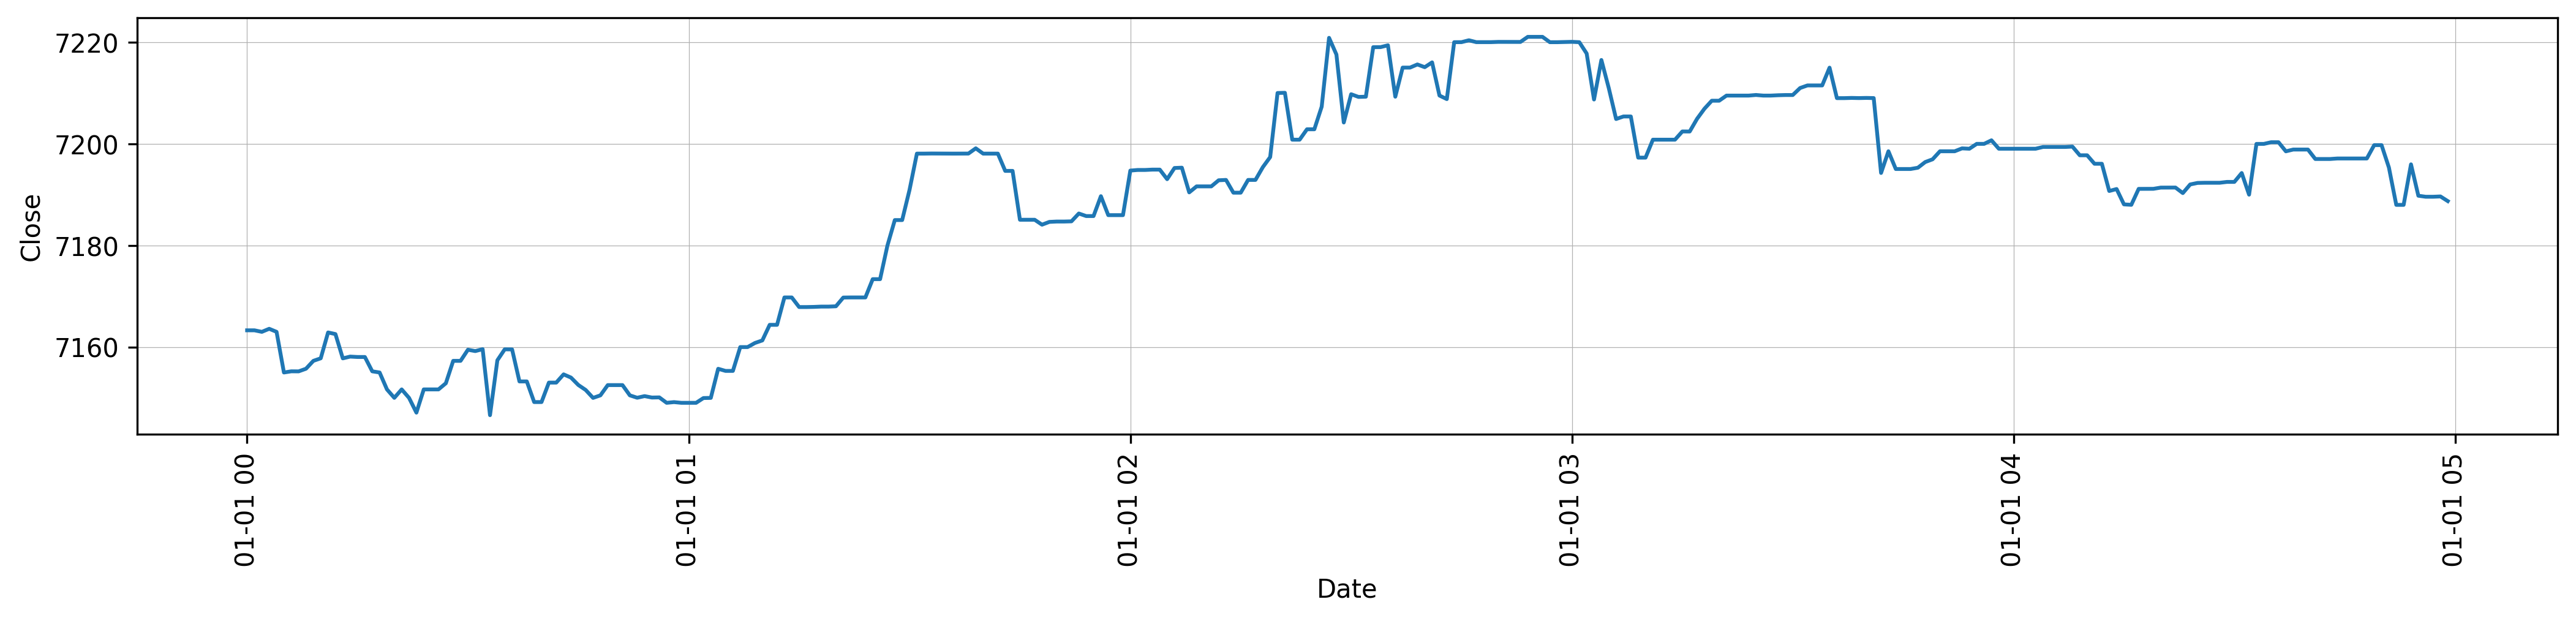

In [4]:
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=df.tail(300), x='Date', y='Close')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

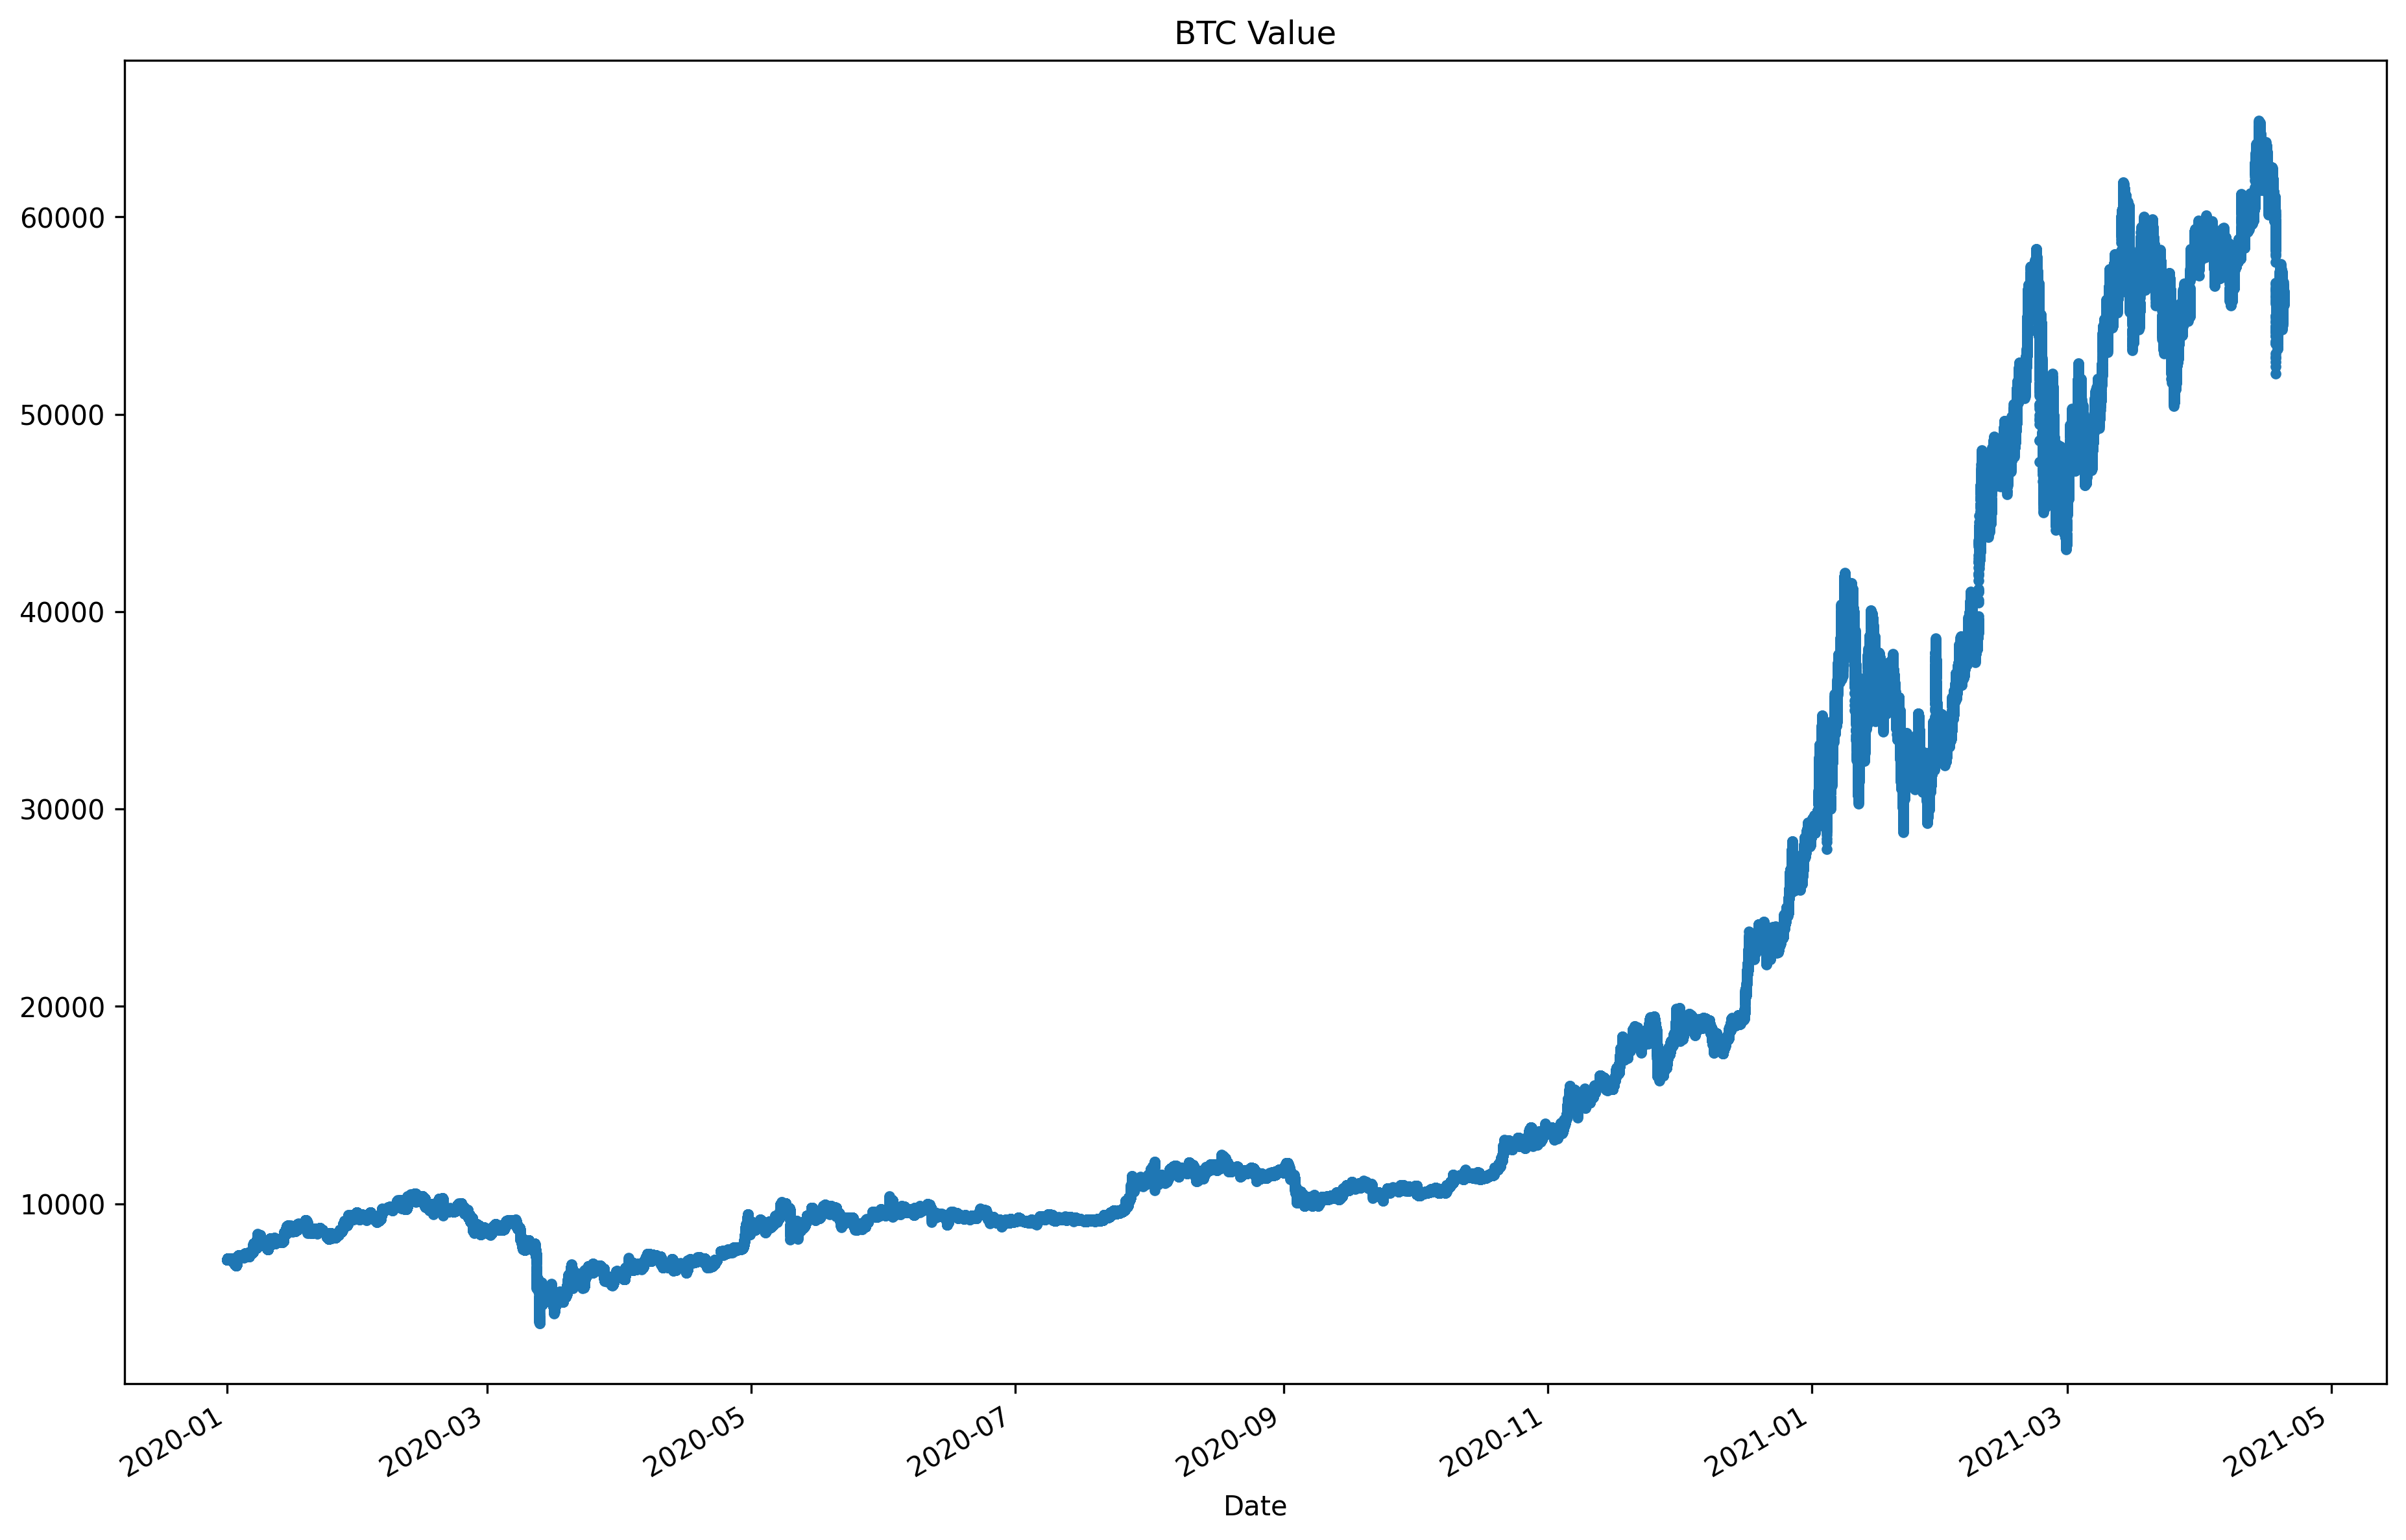

In [5]:
df['Close'].plot(style='.', figsize=(15, 10), title="BTC Value")
plt.show()

In [6]:
data_split = '03-01-2021'
train_data = df.loc[df.index < data_split]
test_data = df.loc[df.index >= data_split]

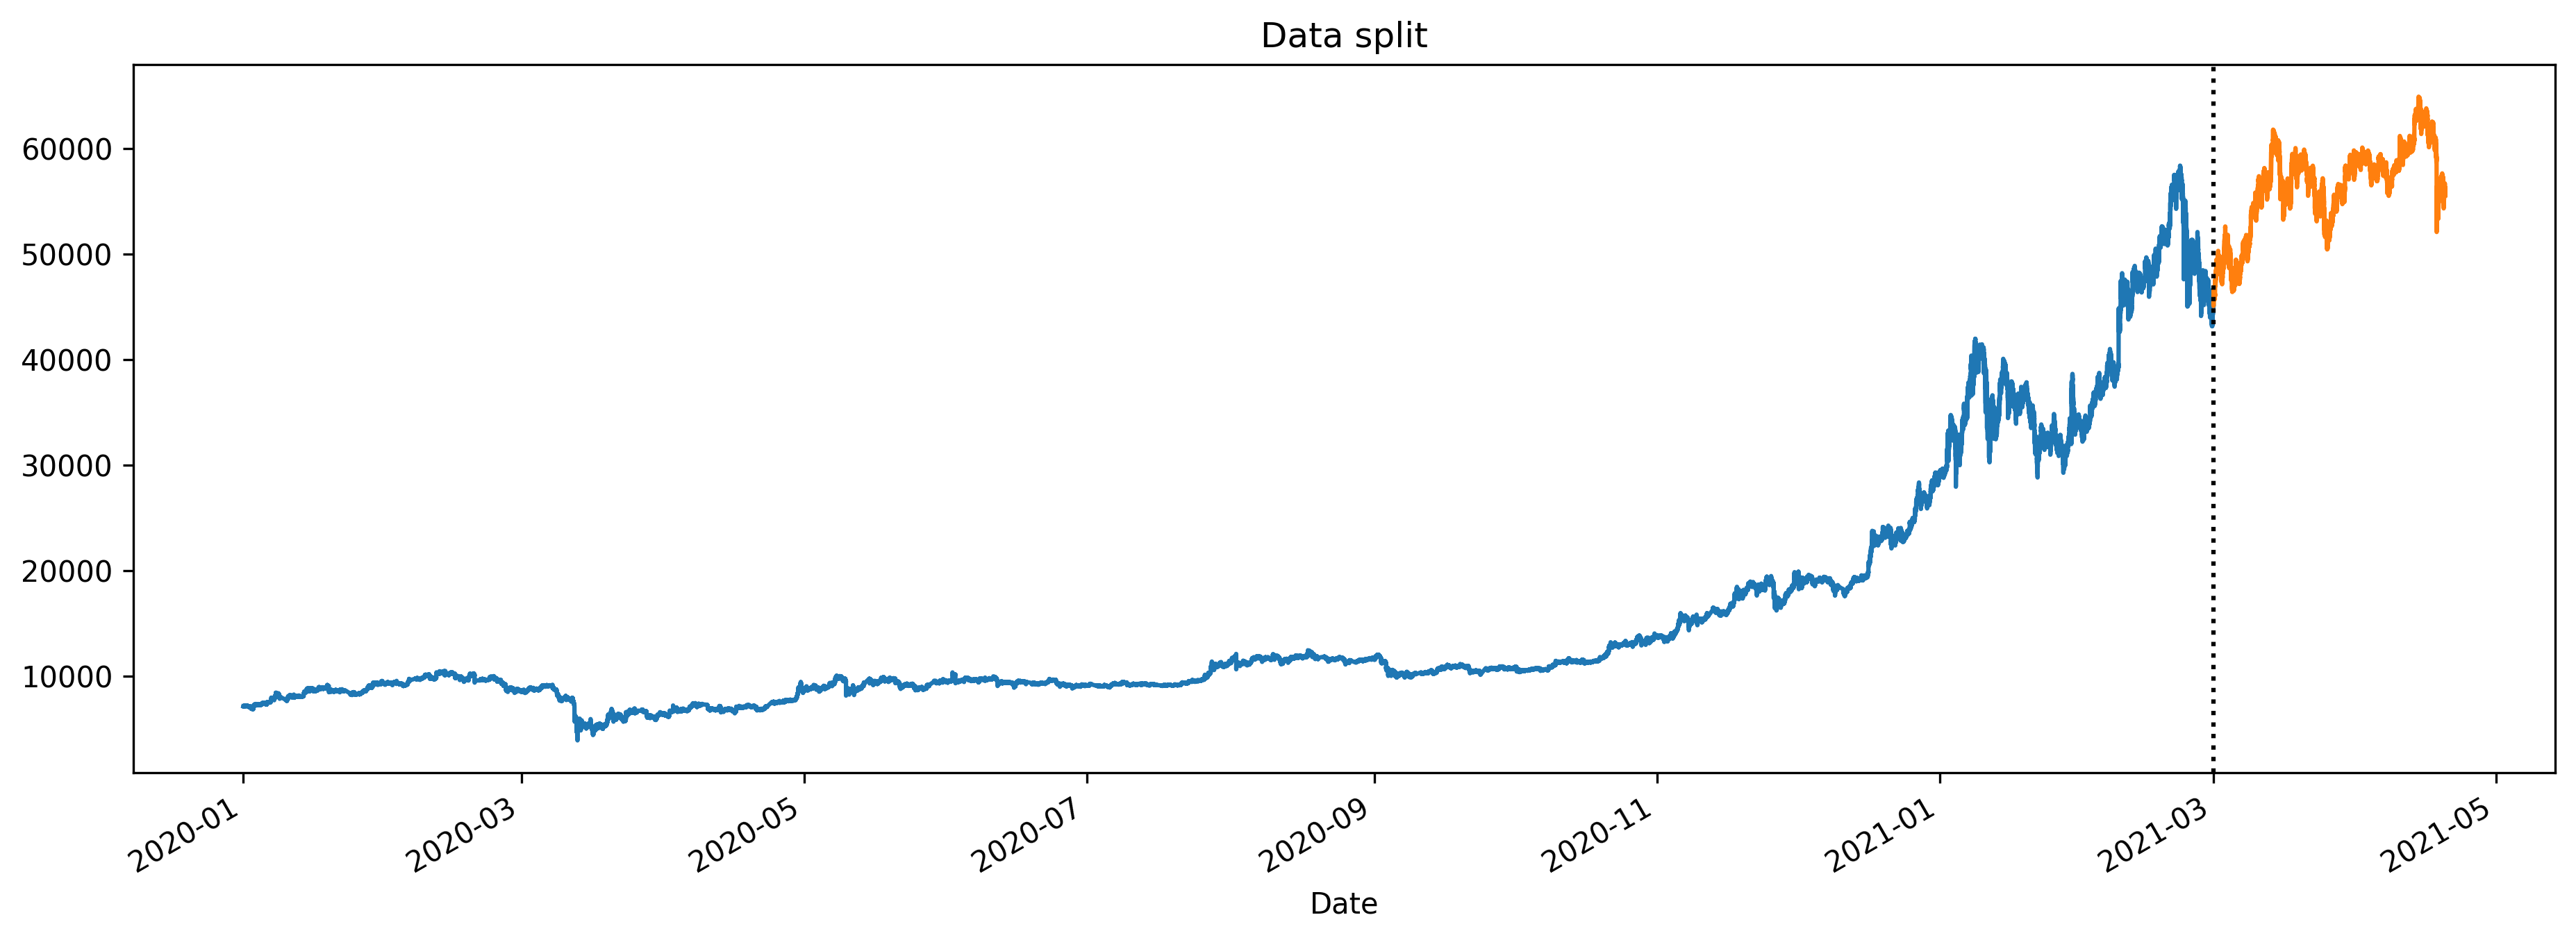

In [7]:
fig, ax = plt.subplots(figsize=(15,5))
train_data['Close'].plot(ax=ax, label='Train data', title="Data split")
test_data['Close'].plot(ax=ax, label='Test Data')
ax.axvline(data_split, color='black', ls='dotted')
plt.show()

<AxesSubplot:xlabel='Date'>

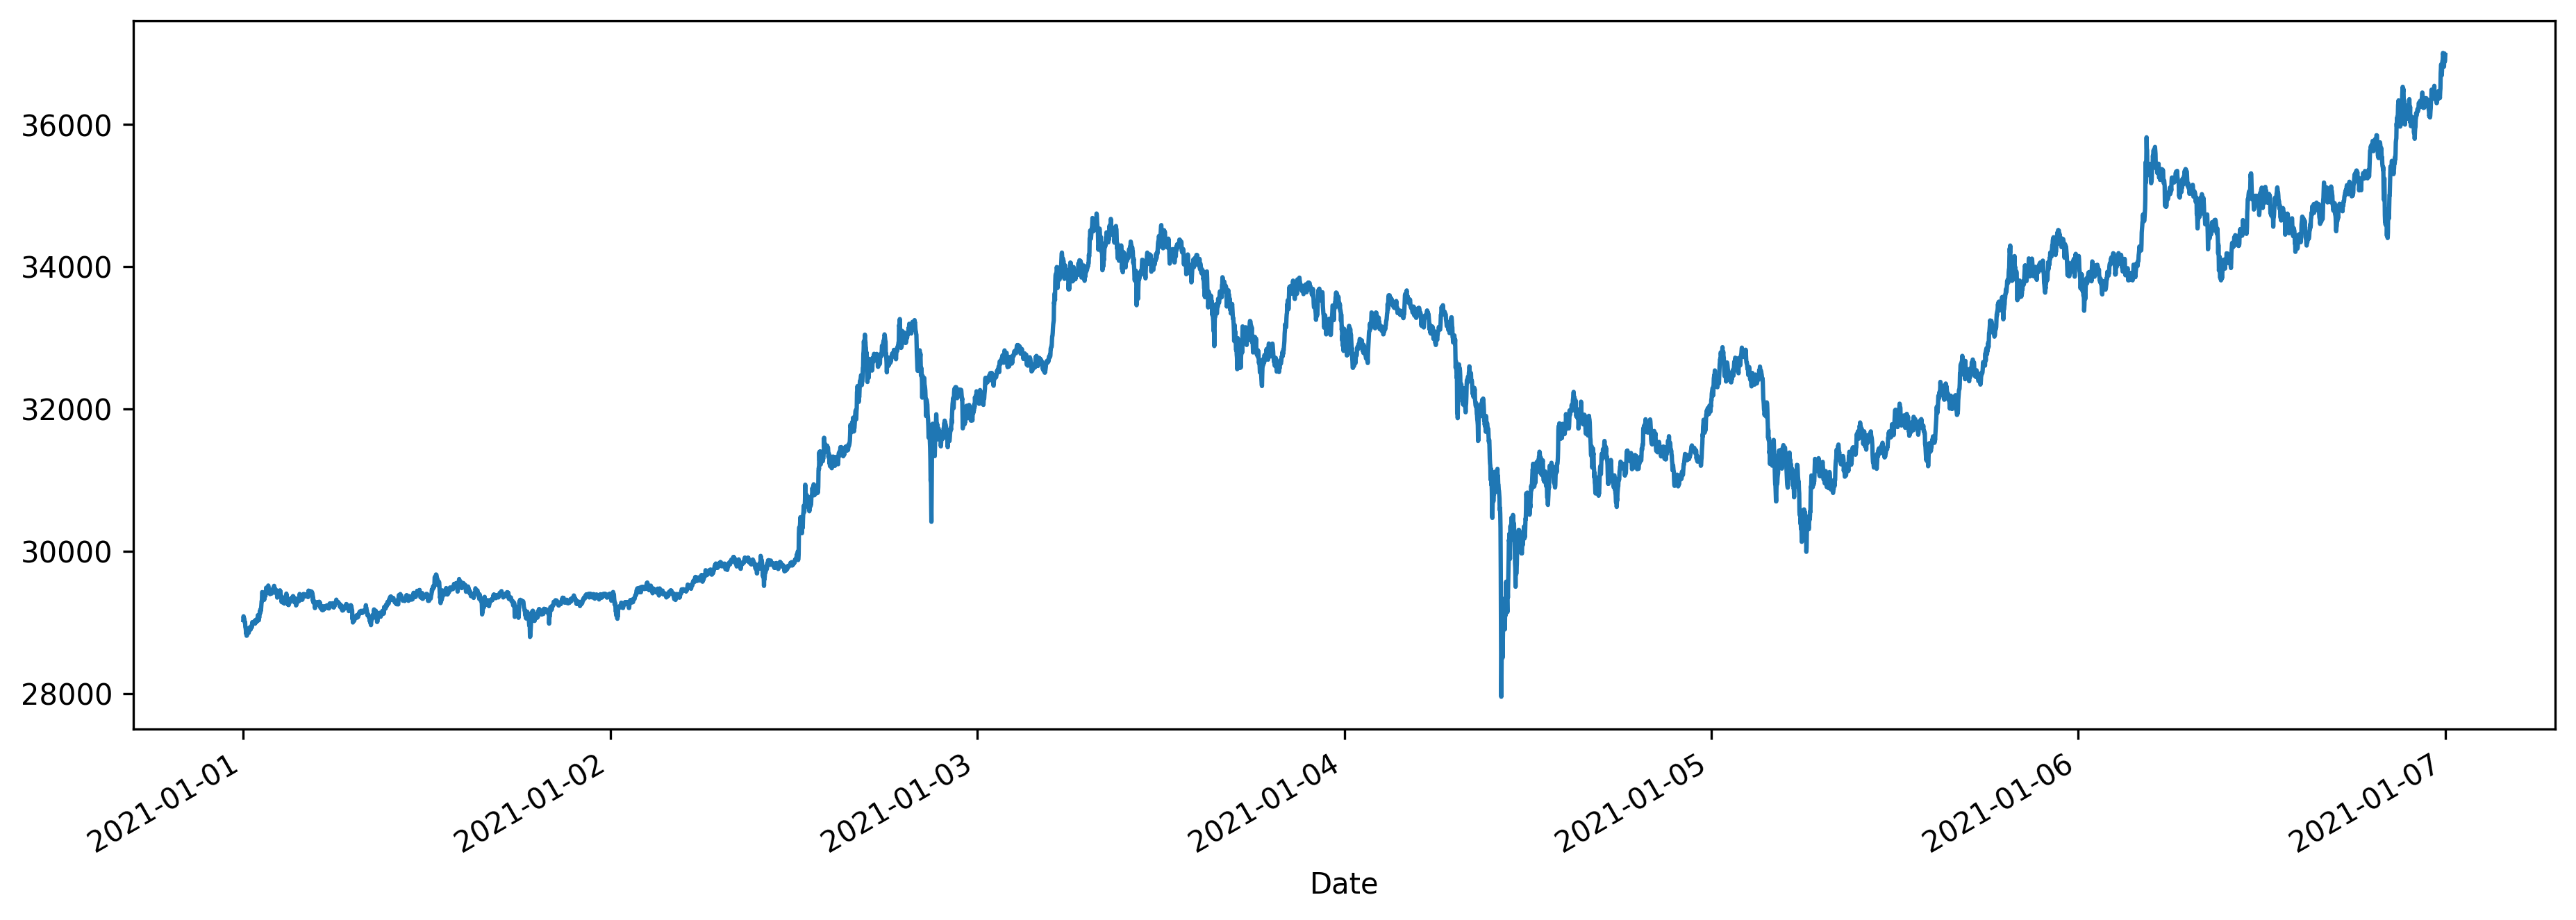

In [8]:
df['Close'].loc[(df.index  >= '01.01.2021') & (df.index <= '01.07.2021')].plot(figsize =(15,5))

In [9]:
def create_features(df):
    df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [10]:
df = create_features(df)

In [11]:
def show_distribution(feature):
    fig, ax = plt.subplots(figsize = (15, 5))
    sns.boxenplot(data=df, x=feature, y='Close')
    ax.set_title(f'Close by {feature}')
    plt.show()

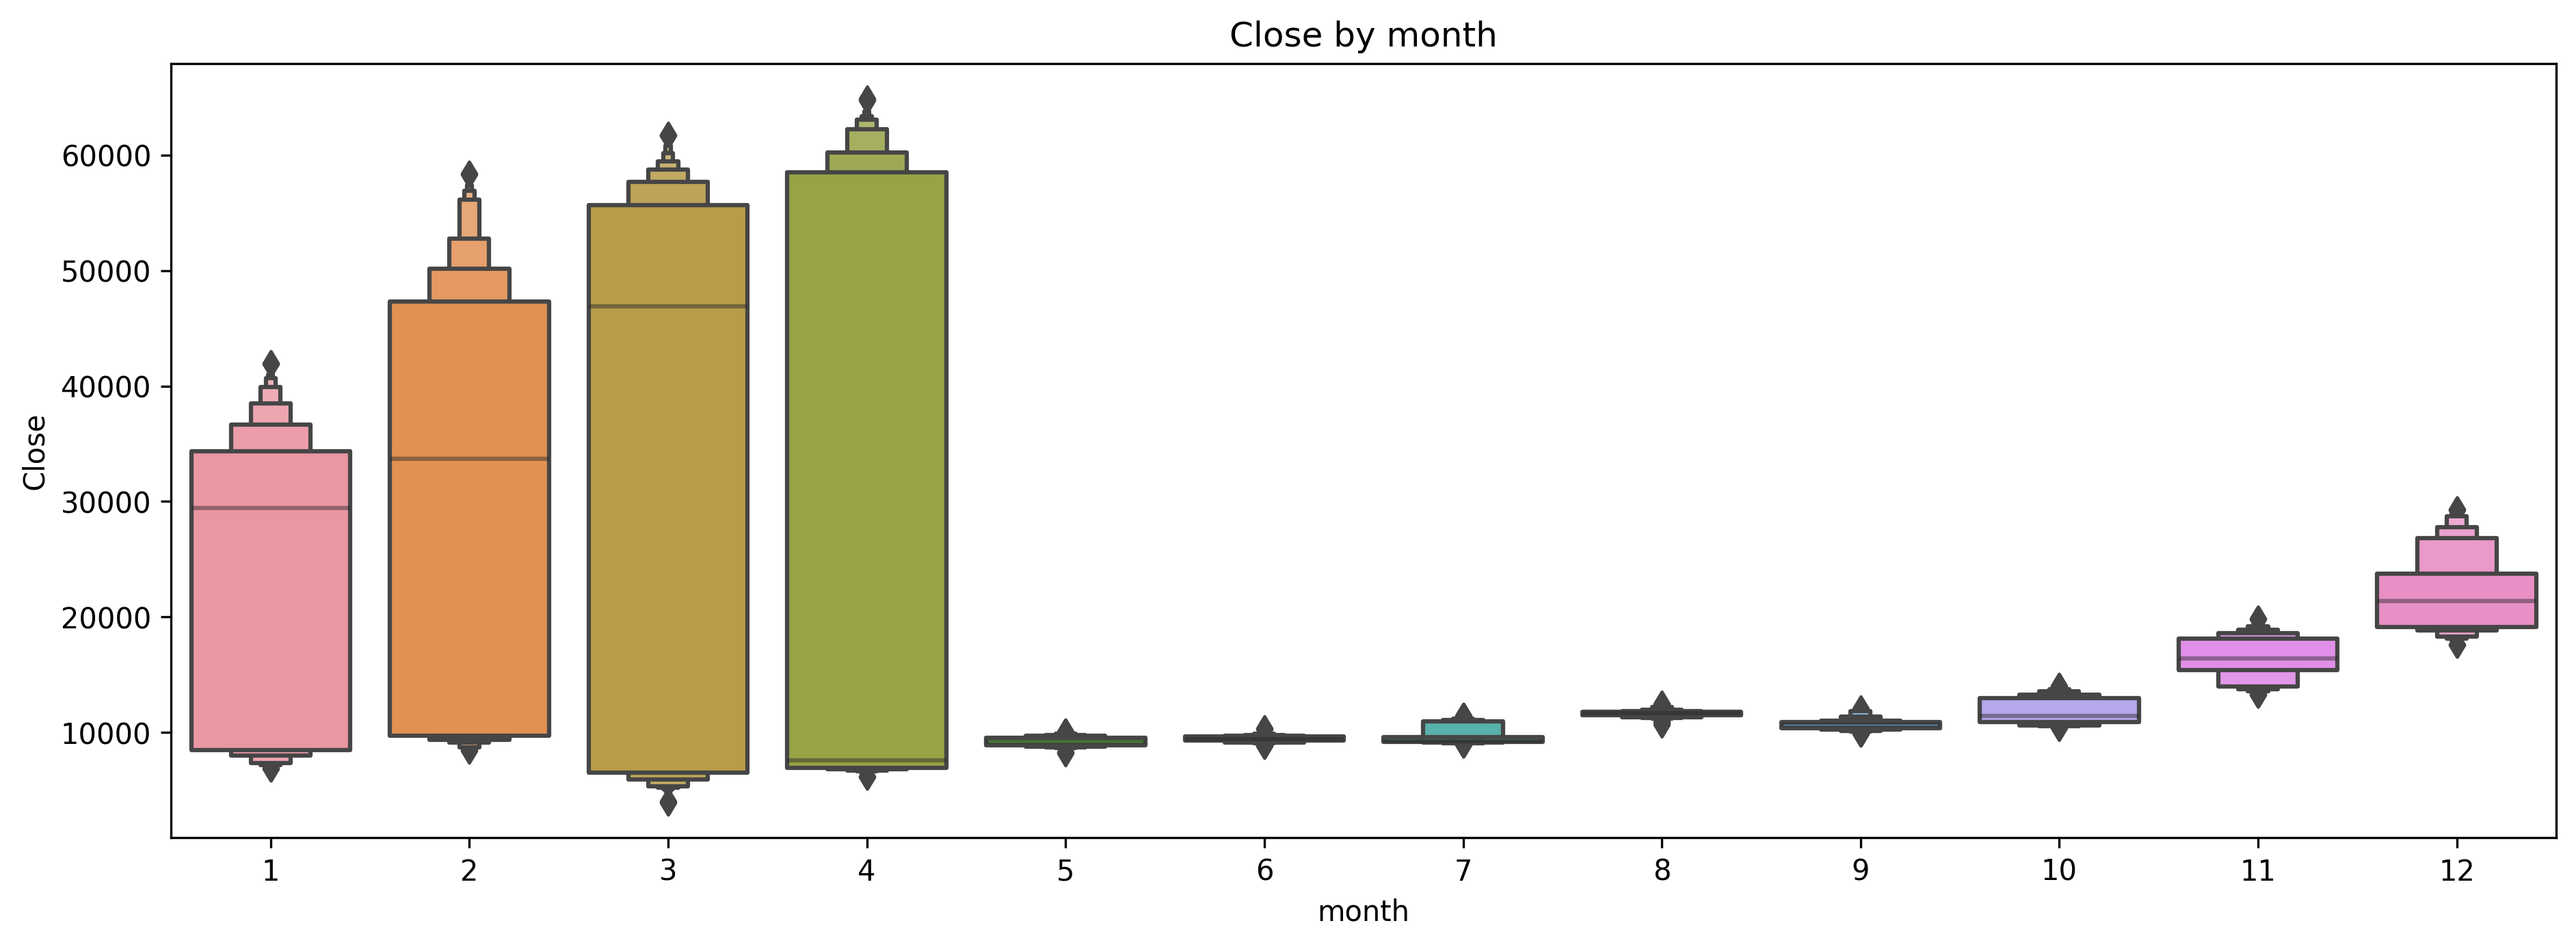

In [12]:
#monthly
show_distribution('month')

In [13]:
model = xgbreg(n_estimators=2000, 
                learning_rate=0.01,
                max_depth = 5,
                max_bin = 8192,
                predictor = 'gpu_predictor',
                objective = "reg:squarederror",
                early_stopping_rounds = 50,
                tree_method='gpu_hist' 
                )

In [14]:
df.columns

Index(['Unix Timestamp', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume',
       'hour', 'dayofweek', 'month', 'year', 'dayofyear'],
      dtype='object')

In [15]:
FEATURES = ['Open', 'High', 'Low', 'Volume', 'hour', 'dayofweek', 'month', 'year', 'dayofyear']
TARGET = ['Close']
train = create_features(train_data)
test = create_features(test_data)

In [16]:
X_train = train[FEATURES]
X_test = test[FEATURES]
y_train = train[TARGET]
y_test = test[TARGET]

In [17]:
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=True
        )

[0]	validation_0-rmse:18841.75854	validation_1-rmse:56029.91653
[1]	validation_0-rmse:18653.43285	validation_1-rmse:55486.22825
[2]	validation_0-rmse:18466.99104	validation_1-rmse:54947.73271
[3]	validation_0-rmse:18282.41293	validation_1-rmse:54414.73057
[4]	validation_0-rmse:18099.68122	validation_1-rmse:53887.13639
[5]	validation_0-rmse:17918.77672	validation_1-rmse:53364.93417
[6]	validation_0-rmse:17739.68151	validation_1-rmse:52847.77899
[7]	validation_0-rmse:17562.37715	validation_1-rmse:52335.60697
[8]	validation_0-rmse:17386.84558	validation_1-rmse:51828.87313
[9]	validation_0-rmse:17213.06978	validation_1-rmse:51326.96623
[10]	validation_0-rmse:17041.03086	validation_1-rmse:50830.40245
[11]	validation_0-rmse:16870.71195	validation_1-rmse:50338.78684
[12]	validation_0-rmse:16702.09605	validation_1-rmse:49849.01232
[13]	validation_0-rmse:16535.16647	validation_1-rmse:49363.84272
[14]	validation_0-rmse:16369.90449	validation_1-rmse:48886.78794
[15]	validation_0-rmse:16206.29248	

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=8192, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=2000,
             n_jobs=0, num_parallel_tree=1, predictor='gpu_predictor',
             random_state=0, reg_alpha=0, reg_lambda=1, ...)

In [18]:
test_data['predictions'] = model.predict(X_test)

In [19]:
test_data.tail()

,Unix Timestamp,Symbol,Open,High,Low,Close,Volume,hour,dayofweek,month,year,dayofyear,predictions
Date,,,,,,,,,,,,,
2021-03-01 00:04:00,1.614560e+12,BTCUSD,45183.63,45186.42,45088.02,45150.63,0.889344,0,0,3,2021,60,45145.242188
2021-03-01 00:03:00,1.614560e+12,BTCUSD,45245.79,45261.84,45183.63,45183.63,0.255290,0,0,3,2021,60,45229.574219
2021-03-01 00:02:00,1.614560e+12,BTCUSD,45417.95,45424.34,45245.79,45245.79,1.044848,0,0,3,2021,60,45385.578125
2021-03-01 00:01:00,1.614560e+12,BTCUSD,45346.05,45417.95,45346.05,45417.95,0.381894,0,0,3,2021,60,45351.351562
2021-03-01 00:00:00,1.614560e+12,BTCUSD,45236.45,45346.05,45236.45,45346.05,0.427531,0,0,3,2021,60,45308.921875


In [20]:
df = df.merge(test_data[['predictions']], how='left', left_index=True, right_index=True)

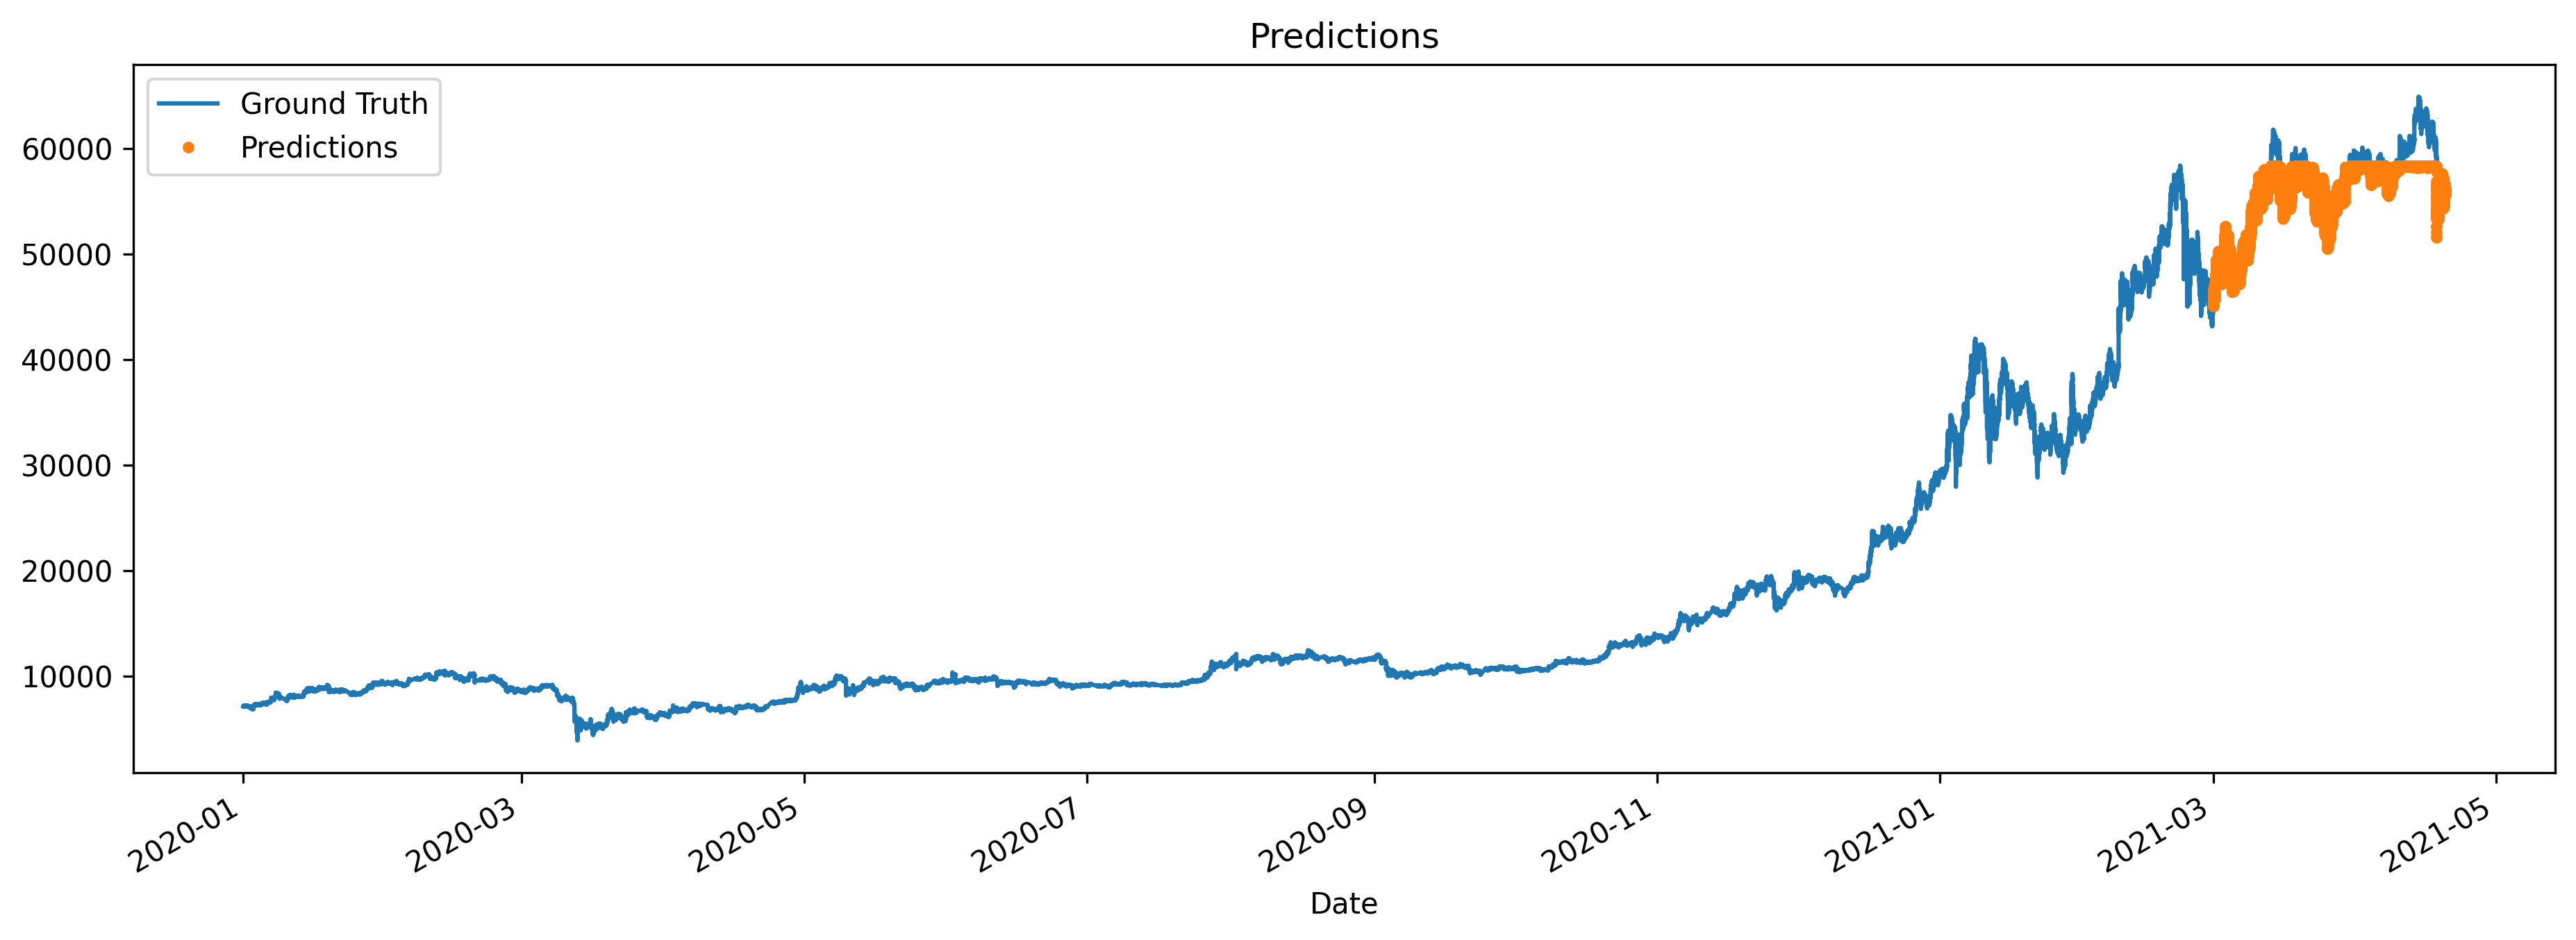

In [21]:
ax = df[['Close']].plot(figsize=(15,5))
df['predictions'].plot(ax=ax, style='.')
plt.legend(['Ground Truth', 'Predictions'])
ax.set_title('Predictions')
plt.show()

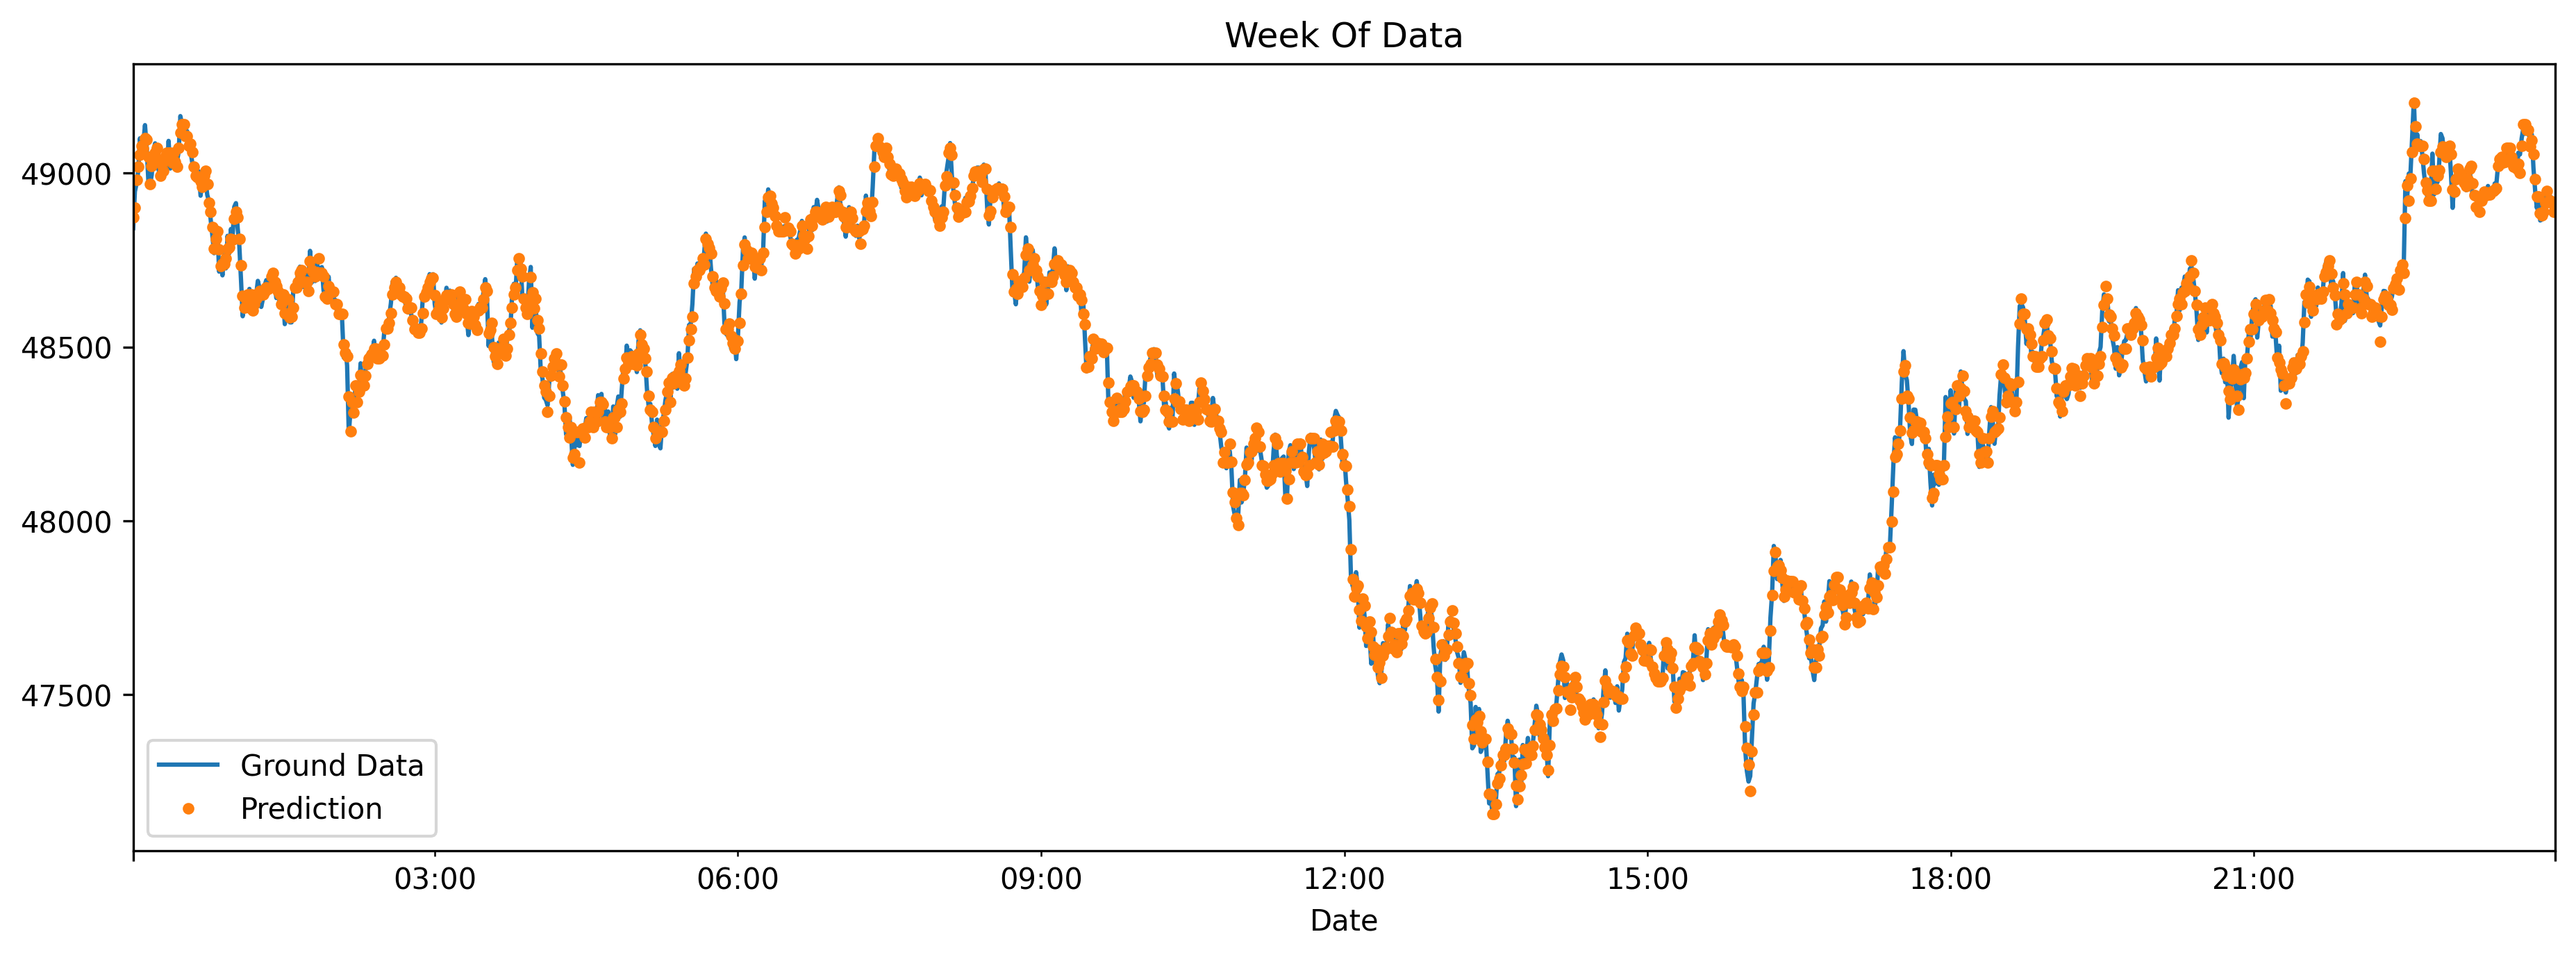

In [22]:
ax = df.loc[(df.index > '2021-03-06') & (df.index < '2021-03-07')]['Close'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index >  '2021-03-06') & (df.index <  '2021-03-07')]['predictions'] \
    .plot(style='.')
plt.legend(['Ground Data','Prediction'])
plt.show()

In [23]:
df.loc[(df.index > '2021-04-16') & (df.index < '2021-04-30')].sort_values(by='Date', ascending=True).head(100)

,Unix Timestamp,Symbol,Open,High,Low,Close,Volume,hour,dayofweek,month,year,dayofyear,predictions
Date,,,,,,,,,,,,,
2021-04-16 00:01:00,1.618530e+12,BTCUSD,63349.82,63362.80,63295.27,63327.34,4.508941,0,4,4,2021,106,58262.792969
2021-04-16 00:02:00,1.618530e+12,BTCUSD,63327.34,63350.13,63294.52,63307.50,4.175692,0,4,4,2021,106,58263.167969
2021-04-16 00:03:00,1.618530e+12,BTCUSD,63297.24,63338.84,63292.98,63292.98,0.058678,0,4,4,2021,106,58268.585938
2021-04-16 00:04:00,1.618530e+12,BTCUSD,63292.98,63325.48,63251.75,63325.48,0.899977,0,4,4,2021,106,58261.074219
2021-04-16 00:05:00,1.618530e+12,BTCUSD,63325.48,63337.94,63303.00,63337.94,0.035385,0,4,4,2021,106,58268.585938
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-16 01:36:00,1.618540e+12,BTCUSD,63107.62,63107.62,63061.30,63073.40,2.864156,1,4,4,2021,106,58247.421875
2021-04-16 01:37:00,1.618540e+12,BTCUSD,63073.40,63073.40,63025.00,63025.01,0.643011,1,4,4,2021,106,58260.578125
2021-04-16 01:38:00,1.618540e+12,BTCUSD,63025.01,63069.06,62934.53,63001.48,1.952553,1,4,4,2021,106,58249.789062


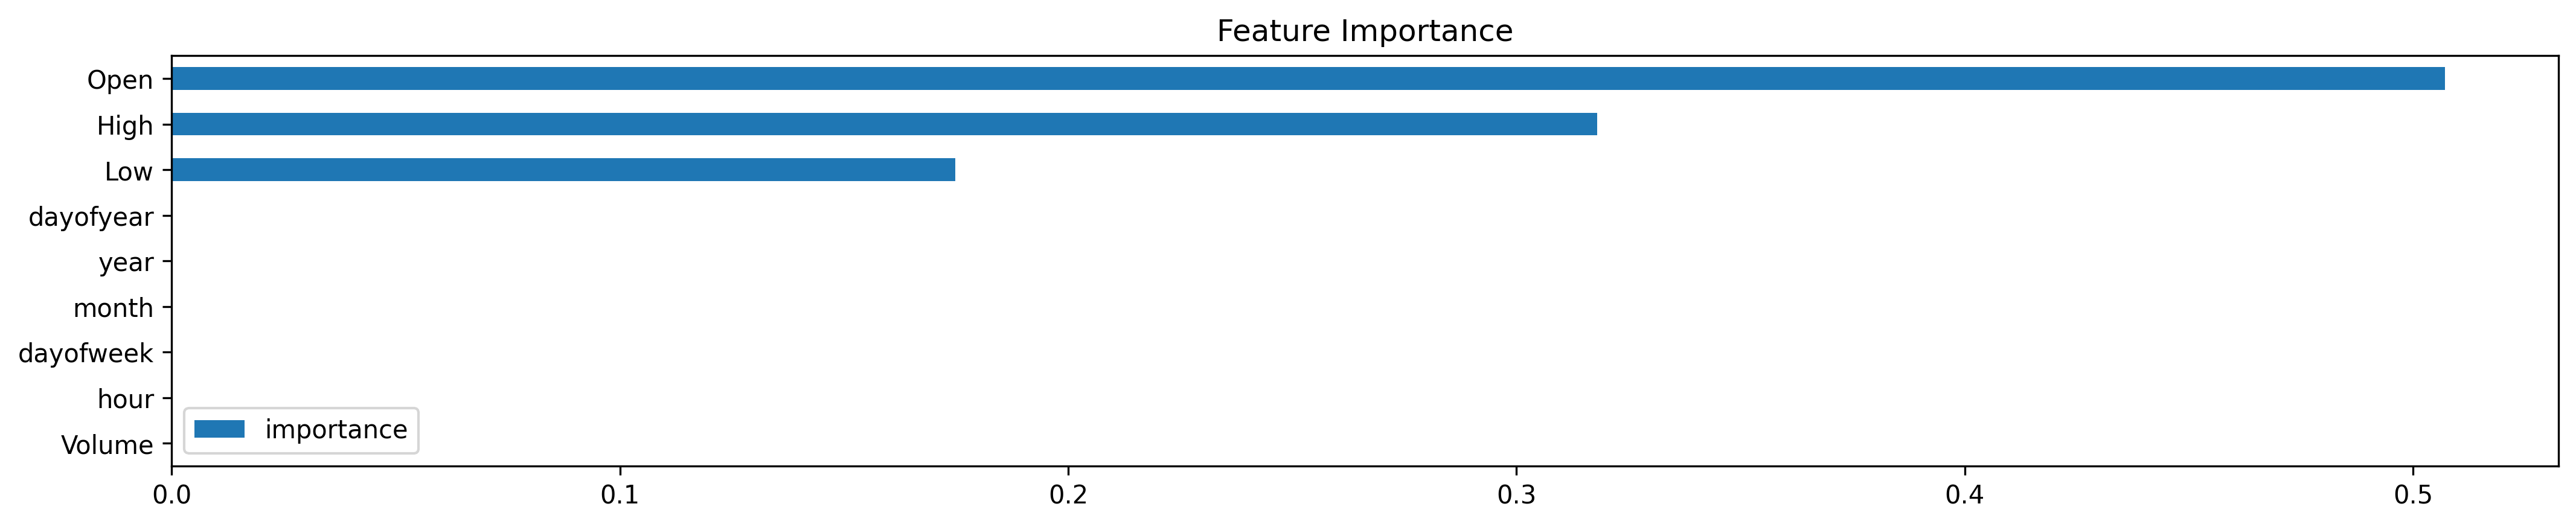

In [32]:
fi = pd.DataFrame(data=model.feature_importances_,
             index=model.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [30]:
fi

,importance
Open,5.070961e-01
High,3.179921e-01
Low,1.748409e-01
Volume,8.926516e-08
hour,1.484257e-07
dayofweek,2.679435e-07
month,1.882430e-06
year,1.547851e-05
dayofyear,5.313855e-05
